# Muscle Latent Analysis

This notebook demonstrates how to analyze latent representations of muscle images using **PCA, LDA, and Fisher scores**, and how to visualize performance metrics across folds for different subject groups. 

We focus on the muscle **RF (Rectus Femoris)** and perform the following steps:

1. Load subject lists and categorize them.
2. Parse model log files to extract latent vectors and metrics.
3. Perform **PCA + MANOVA** for multivariate analysis.
4. Apply **LDA** to visualize group separation and compute **Fisher scores**.
5. Generate **boxplots** for evaluation metrics across test sets and folds.
6. Perform **mixed-effects analysis** to compute the p-value for DSC differences between groups.

This notebook is structured to support modular execution: you can choose to perform LDA analysis, boxplots, or both.


In [1]:
# Import necessary libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import mixedlm
from IPython.display import display

# Set plotting style
sns.set(style="whitegrid")


## 1. Configuration

Define key variables, output paths, and flags to control which analyses will run.

- `muscle`: muscle to analyze (here RF)
- `n_folds`: number of cross-validation folds
- `do_lda`: whether to perform LDA + Fisher analysis
- `do_boxplots`: whether to generate boxplots for metrics only


In [2]:
# ----------------------------
# CONFIGURATION
# ----------------------------
muscle = 'RF'
n_folds = 5
output_csv = f"fisher_scores_and_metrics_{muscle}.csv"
output_dir = f"plots_{muscle}"
os.makedirs(output_dir, exist_ok=True)

# Flags to control analysis
do_lda = False        # Perform LDA + Fisher + scatter plots
do_boxplots = True   # Generate boxplots of metrics only


## 2. Common Variables

Define plotting colors, markers, and group name mappings for clarity in plots.  
We also initialize lists to store results and combined metric data.


In [3]:
# ----------------------------
# COMMON VARIABLES
# ----------------------------
colors = {
    'patient_with_sarcopenia': 'red',
    'patients_wo_sarcopenia': 'green',
    'healthy_subjects': 'blue'
}
markers = {'Train': 'x', 'Test': 'o'}
group_name_mapping = {
    'healthy_subjects': 'young_adults',
    'patients_wo_sarcopenia': 'older_adults_wo_sarcopenia',
    'patient_with_sarcopenia': 'older_adults_with_sarcopenia',
}
fold_palette = sns.color_palette("Set1", n_colors=n_folds)

results = []
df_combined_list = []


## 3. Helper Functions

We define functions to:

1. Load subject lists and assign groups.
2. Parse log files for latent vectors and metrics.
3. Convert tensor strings into numpy arrays.

These functions modularize the workflow and keep the main loop cleaner.


In [4]:
# ----------------------------
# FUNCTIONS
# ----------------------------

def load_subjects(file_path, group=None):
    """Load subjects from a text file and assign a group (optional)."""
    with open(file_path, 'r') as f:
        subjects = [line.strip().lower() for line in f]
    if group:
        return pd.DataFrame({'Subject': subjects, 'Group': group})
    return subjects

def categorize_subjects(subjects):
    """Categorize subjects into healthy vs patients without sarcopenia."""
    categorized = []
    for subj in subjects:
        if subj.startswith('sujet'):
            categorized.append({'Subject': subj, 'Group': 'healthy_subjects'})
        else:
            categorized.append({'Subject': subj, 'Group': 'patients_wo_sarcopenia'})
    return pd.DataFrame(categorized)

def parse_log_file(path):
    """Parse log.txt file to extract latent vectors and metrics."""
    parsed_data = []
    if not os.path.isfile(path):
        return pd.DataFrame()
    with open(path, 'r') as file:
        lines = file.readlines()
    batch_cases, z_latents_batch_str, stats = [], "", {}
    stats_pattern = (r"ASD: ([\d.]+), HSD: ([\d.]+), HSD95: ([\d.]+), DSC: ([\d.]+), "
                     r"err_vol_cm_3: ([\d.]+), err_vol_percent: ([\d.]+)")
    i = 0
    while i < len(lines):
        line = lines[i]
        if "Batch cases: " in line:
            batch_cases = line.strip().replace("Batch cases: ", "").split(', ')
        elif batch_cases and "z:" in line:
            tensor_lines = [line.strip().split('z:')[1].strip()]
            i += 1
            while i < len(lines) and ("tensor" in lines[i] or " " in lines[i]):
                tensor_lines.append(lines[i].strip())
                i += 1
            z_latents_batch_str = ' '.join(tensor_lines)
            continue
        elif batch_cases and "Batch ASD:" in line:
            match = re.search(stats_pattern, line)
            stats = {k: float(v) for k, v in zip(
                ['ASD','HSD','HSD95','DSC','Err_Vol_CM3','Err_Vol_Percent'], match.groups()
            )} if match else {k: None for k in ['ASD','HSD','HSD95','DSC','Err_Vol_CM3','Err_Vol_Percent']}
            for case in batch_cases:
                parsed_data.append((case.strip().lower(), z_latents_batch_str, *stats.values()))
            batch_cases, z_latents_batch_str, stats = [], "", {}
        i += 1
    columns = ['Subject','z_latents_batch','ASD','HSD','HSD95','DSC','Err_Vol_CM3','Err_Vol_Percent']
    return pd.DataFrame(parsed_data, columns=columns)

def convert_tensor_string_to_array(tensor_str):
    """Convert tensor string from log file into numpy array."""
    tensor_str = re.sub(r'Parameter containing:', '', tensor_str).strip()
    tensor_str = tensor_str.replace("tensor(", "").split(", device=")[0]
    try:
        return np.array(literal_eval(tensor_str))
    except:
        return None


## 4. Configurable File Paths

Before running the main loop, we define all paths to subject lists and log files in a centralized section.  
This allows you to easily modify the dataset or muscle of interest without changing the core code.  

You can update:

- `base_subject_dir`: directory containing subject list files (train, test, sarcopenia)
- `base_log_dir`: directory containing evaluation log files
- `log_template`: adapt with the name of your output folder./output/<name_of_output_folder>/


In [5]:
# ----------------------------
# CONFIGURABLE PATHS
# ----------------------------

# Base directories for subject files and log files
base_subject_dir = '../casename_files/DIASEM'
base_log_dir = '../../ImplicitFunction/output/DIASEM_NOT_MISMATCH'

# TEMPLATE FOR LOG PATHS
log_template = f"DIASEM_{muscle}_set{{fold}}_NO_MISMATCH_registered_turned_1500_eval_ax2_x1_"

# Automatically create output directories
output_dir = f"plots_{muscle}"
os.makedirs(output_dir, exist_ok=True)
output_csv = f"fisher_scores_and_metrics_{muscle}.csv"


## 5. Main Loop Per Fold (with Configurable Paths)

In the main loop, the paths to subject lists and log files are constructed dynamically using the configuration above.  
This makes it easy to switch muscles, folds, or directories without modifying the loop itself.

Make sure you have the right folder names so the log_paths could work.


In [6]:
# ----------------------------
# MAIN LOOP PER FOLD
# ----------------------------
for fold in range(1, n_folds + 1):
    print(f"Processing fold {fold}...")

    # Paths to subject lists
    path_sarcopenia = os.path.join(base_subject_dir, muscle, 'sarcopenia_subj_DIASEM.txt')
    path_train = os.path.join(base_subject_dir, muscle, f'train_cases_{fold}.txt')
    path_test = os.path.join(base_subject_dir, muscle, f'test_cases_{fold}.txt')

    # Paths to log files
    # TODO: Modify the name of the output folder with your own path names
    log_paths = {
        'test': os.path.join(base_log_dir, log_template.format(fold=fold) + 'healthy', 'log.txt'),
        'sarcopenia': os.path.join(base_log_dir, log_template.format(fold=fold) + 'sarcopenia', 'log.txt'),
        'train': os.path.join(base_log_dir, log_template.format(fold=fold) + 'train', 'log.txt')
    }

    # ----------------------------
    # LDA ANALYSIS
    # ----------------------------
    if do_lda:
        sarcopenia_df = load_subjects(path_sarcopenia, 'patient_with_sarcopenia')
        train_df = categorize_subjects(load_subjects(path_train))
        test_df = categorize_subjects(load_subjects(path_test))

        log_test = parse_log_file(log_paths['test'])
        log_sarc = parse_log_file(log_paths['sarcopenia'])
        log_train = parse_log_file(log_paths['train'])

        for df in [log_test, log_sarc, log_train]:
            if not df.empty:
                df['Subject'] = df['Subject'].str.strip("[]").str.replace("'", "")
                df['z_latents_batch'] = df['z_latents_batch'].apply(convert_tensor_string_to_array)

        log_test = log_test.merge(test_df, on='Subject', how='left').assign(Set='Test')
        log_sarc = log_sarc.merge(sarcopenia_df, on='Subject', how='left').assign(Set='Test')
        log_train = log_train.merge(train_df, on='Subject', how='left').assign(Set='Train')

        combined_df = pd.concat([log_test, log_sarc, log_train], ignore_index=True)

        # Filter by most frequent latent vector shape
        shapes = combined_df['z_latents_batch'].apply(lambda x: x.shape if x is not None else None)
        if shapes.dropna().empty:
            continue
        most_common_shape = Counter(shapes.dropna()).most_common(1)[0][0]
        df_filtered = combined_df[combined_df['z_latents_batch'].apply(lambda x: x is not None and x.shape == most_common_shape)]
        if df_filtered.empty:
            continue

        X = np.stack(df_filtered['z_latents_batch'].values)
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        y = df_filtered['Group'].values

        # PCA + MANOVA
        n_components = min(64, X.shape[1])
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        df_latents = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
        df_latents["Group"] = y

        formula = " + ".join([f"PC{i+1}" for i in range(X_pca.shape[1])]) + " ~ Group"
        maov = MANOVA.from_formula(formula, data=df_latents)
        manova_res = maov.mv_test()
        p_value = manova_res.results['Group']['stat']['Pr > F']['Wilks\' lambda']
        print(f"Fold {fold} MANOVA p-value:", p_value)

        # LDA + Fisher score
        lda = LDA(n_components=2)
        z_lda = lda.fit_transform(X, y)

        classes = np.unique(y)
        overall_mean = np.mean(z_lda, axis=0)
        S_B, S_W = np.zeros((2,2)), np.zeros((2,2))
        for cls in classes:
            X_c = z_lda[y == cls]
            mean_c = np.mean(X_c, axis=0)
            n_c = X_c.shape[0]
            mean_diff = (mean_c - overall_mean).reshape(-1, 1)
            S_B += n_c * (mean_diff @ mean_diff.T)
            S_W += np.cov(X_c, rowvar=False) * (n_c - 1)
        fisher_score_multi = np.trace(S_B) / np.trace(S_W)
        results.append({'fold': fold, 'fisher_score': fisher_score_multi, 'p_value': p_value})

        # Scatter plot LDA
        plt.figure(figsize=(10, 9))
        labels_added = set()
        for idx, row in df_filtered.iterrows():
            marker = markers.get(row['Set'], 'o')
            color = colors.get(row['Group'], 'gray')
            group_label = group_name_mapping.get(row['Group'], row['Group'])
            if group_label not in labels_added:
                plt.scatter(z_lda[idx,0], z_lda[idx,1], c=color, marker=marker, alpha=0.7, label=group_label)
                labels_added.add(group_label)
            else:
                plt.scatter(z_lda[idx,0], z_lda[idx,1], c=color, marker=marker, alpha=0.7)
        for set_type, marker in markers.items():
            plt.scatter([], [], color='black', marker=marker, label=set_type)
        plt.xlabel('LDA Component 1', fontsize=16)
        plt.ylabel('LDA Component 2', fontsize=16)
        plt.legend(title="Group and Set", fontsize=12)
        plt.title(f'LDA fold {fold}\nFisher score: {fisher_score_multi:.2f}\np-value (MANOVA): '
                  f'{"<0.001" if p_value < 0.001 else f"{p_value:.4f}"}', fontsize=16)
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f"lda_fold_{fold}.png"))
        plt.show()

        # Add metrics for boxplots
        for test_set, log_file, label in zip(['healthy','sarcopenia'],
                                             [log_paths['test'], log_paths['sarcopenia']],
                                             ['healthy','sarcopenia']):
            df_metrics = parse_log_file(log_file)
            if not df_metrics.empty:
                df_metrics['fold'] = fold
                df_metrics['source'] = f'Fold_{fold}_Test_Set_{label}'
                df_combined_list.append(df_metrics)

    # ----------------------------
    # BOXPLOTS ONLY (without LDA)
    # ----------------------------
    if do_boxplots and not do_lda:
        for label, log_file in zip(['healthy','sarcopenia'], [log_paths['test'], log_paths['sarcopenia']]):
            df_metrics = parse_log_file(log_file)
            if not df_metrics.empty:
                df_metrics['fold'] = fold
                df_metrics['source'] = f'Fold_{fold}_Test_Set_{label}'
                df_combined_list.append(df_metrics)

Processing fold 1...
Processing fold 2...
Processing fold 3...


## 6. Combine Metrics and Save Results

After processing all folds, we combine metrics and Fisher scores (if LDA was performed), save to a CSV, and display results.


In [7]:
# ----------------------------
# COMBINE METRICS AND SAVE
# ----------------------------
if df_combined_list:
    df_combined = pd.concat(df_combined_list, ignore_index=True)
    df_results = pd.DataFrame(results) if do_lda else pd.DataFrame()
    if not df_results.empty:
        df_final = df_combined.merge(df_results, on='fold', how='left')
    else:
        df_final = df_combined
    df_final.to_csv(output_csv, index=False)
    print("Results saved to", output_csv)
    display(df_final)


Results saved to fisher_scores_and_metrics_RF.csv


,Subject,z_latents_batch,ASD,HSD,HSD95,DSC,Err_Vol_CM3,Err_Vol_Percent,fold,source
0,['fd121_rf'],"Parameter containing: tensor([[ 0.9317, 0.559...",0.3026,8.8345,1.7002,0.9523,0.2506,0.2392,1,Fold_1_Test_Set_healthy
1,['gd123_rf'],"Parameter containing: tensor([[-0.9311, 0.275...",0.2603,4.7988,1.5996,0.9493,0.1883,0.2465,1,Fold_1_Test_Set_healthy
2,['ij157_rf'],"Parameter containing: tensor([[ 0.5412, 0.148...",0.4125,6.3029,1.9004,0.9256,0.6040,0.7205,1,Fold_1_Test_Set_healthy
3,['le120_rf'],"Parameter containing: tensor([[-0.4914, -0.146...",0.4969,8.6693,1.7002,0.9284,0.3047,0.2148,1,Fold_1_Test_Set_healthy
4,['pj165_rf'],"Parameter containing: tensor([[ 1.1387, -0.319...",0.3596,5.8896,1.7002,0.9311,0.1769,0.2471,1,Fold_1_Test_Set_healthy
...,...,...,...,...,...,...,...,...,...,...
115,['pp104_rf'],"Parameter containing: tensor([[-0.2993, -0.606...",0.3990,12.1861,1.5000,0.9413,0.0135,0.0152,3,Fold_3_Test_Set_sarcopenia
116,['qp108_rf'],"Parameter containing: tensor([[ 0.9578, -0.146...",0.4345,13.1624,2.1213,0.9204,0.3341,0.4454,3,Fold_3_Test_Set_sarcopenia
117,['ra150_rf'],"Parameter containing: tensor([[-0.9669, -0.543...",0.3762,6.4893,1.7998,0.9228,0.5657,0.5720,3,Fold_3_Test_Set_sarcopenia
118,['rj136_rf'],"Parameter containing: tensor([[-1.4393, 0.549...",0.3076,4.7434,1.5000,0.9362,0.2497,0.3524,3,Fold_3_Test_Set_sarcopenia


## 7. Mixed-Effects Model for DSC

We compute a mixed-effects model to test for significant differences in **DSC** between healthy subjects and sarcopenia patients, accounting for repeated measures across folds.


In [8]:
# ----------------------------
# MIXED-EFFECTS DSC P-VALUE
# ----------------------------
dfs = {}
for i in range(1, n_folds + 1):
    for group in ["healthy", "sarcopenia"]:
        key = f"Fold_{i}_{group}"
        dfs[key] = df_combined.loc[
            df_combined["source"] == f"Fold_{i}_Test_Set_{group}", 
            ["Subject", "DSC"]
        ].reset_index(drop=True)

df_all = pd.concat([
    dfs[f"Fold_{i}_healthy"].assign(Group="healthy", Fold=f"Fold_{i}") for i in range(1,n_folds+1)
])
df_all = pd.concat([
    df_all,
    pd.concat([dfs[f"Fold_{i}_sarcopenia"].assign(Group="sarcopenia", Fold=f"Fold_{i}") for i in range(1,n_folds+1)])
])

df_all["Group"] = df_all["Group"].astype("category")
df_all["Fold"] = df_all["Fold"].astype("category")
df_all["Subject"] = df_all["Subject"].astype("category")

model = mixedlm("DSC ~ Group + Fold", df_all, groups=df_all["Subject"])
result = model.fit()
p_value_group = result.pvalues["Group[T.sarcopenia]"]
print(f"P-value for Group effect (healthy vs sarcopenia): {p_value_group:.6f}")


P-value for Group effect (healthy vs sarcopenia): 0.000093


/home/jupyter-piecuch-l/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 8. Boxplots of Metrics Across Folds

We visualize the distribution of evaluation metrics across folds for healthy and sarcopenia subjects.  
- `ASD`, `HSD`, `HSD95` are distance metrics.
- `DSC` is the Dice similarity coefficient.
- `Err_Vol_CM3` and `Err_Vol_Percent` quantify volumetric errors.


/tmp/ipykernel_2423881/4038155718.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


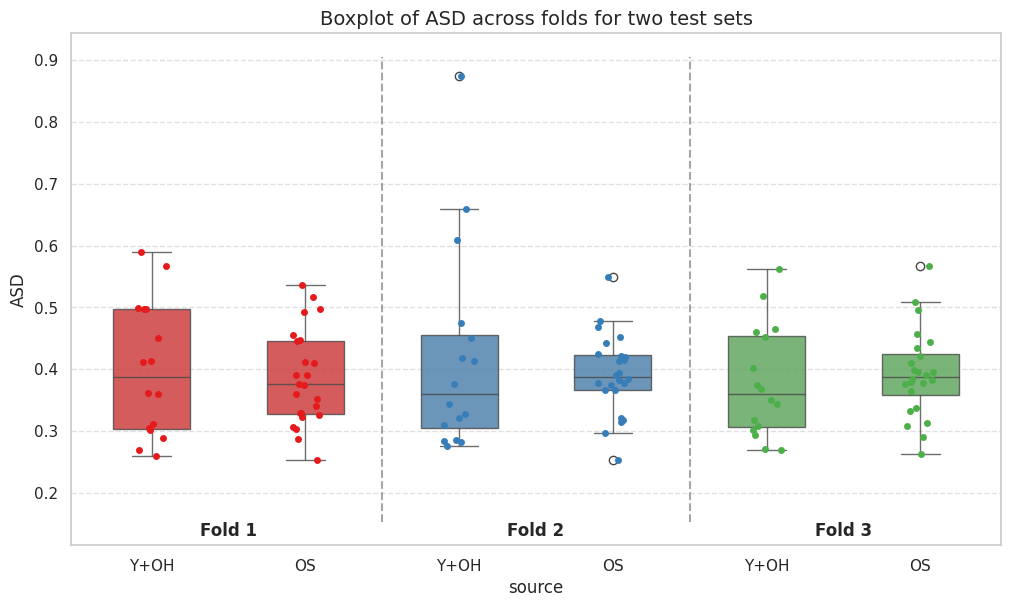

/tmp/ipykernel_2423881/4038155718.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


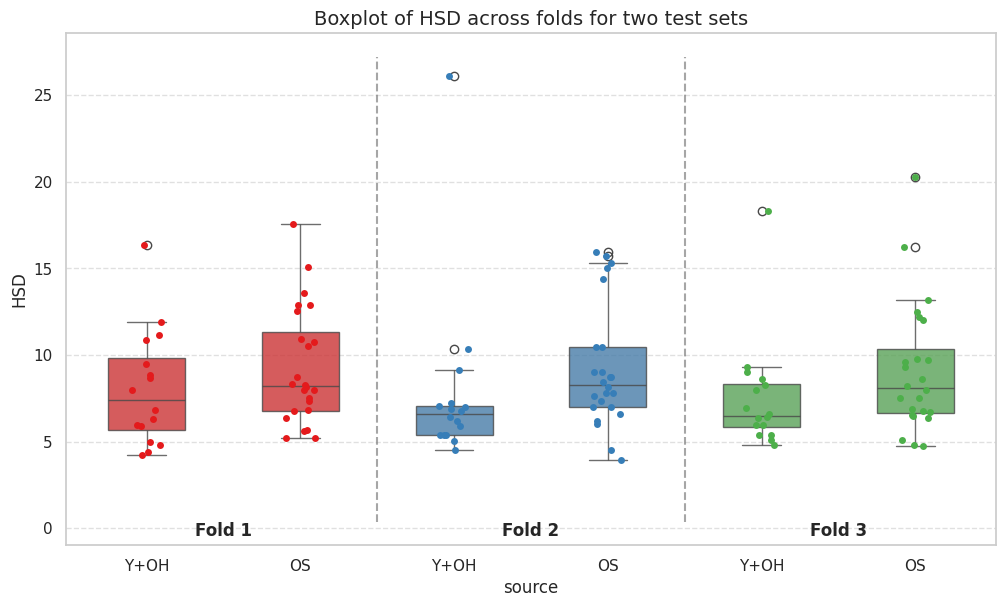

/tmp/ipykernel_2423881/4038155718.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


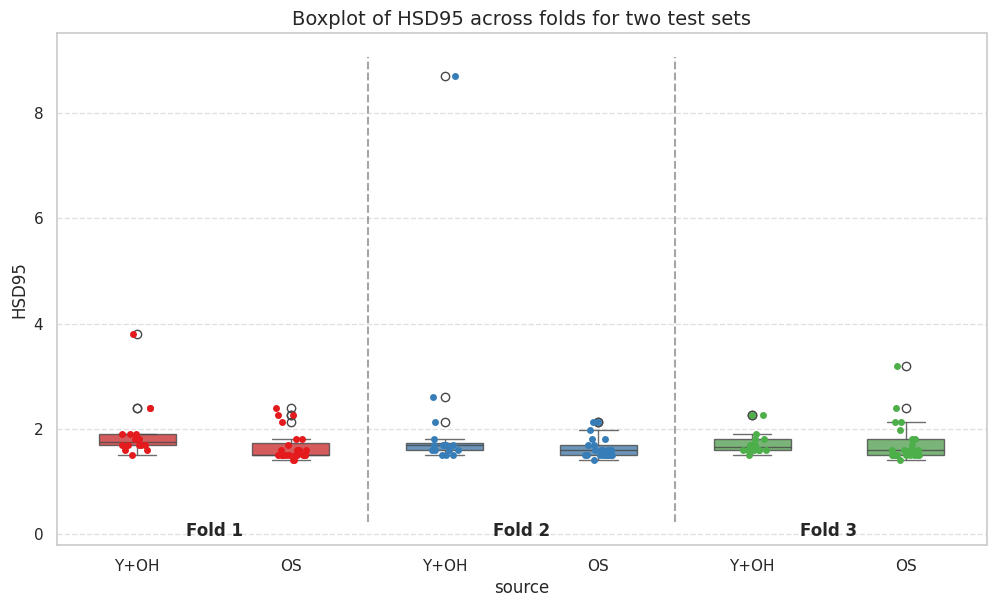

/tmp/ipykernel_2423881/4038155718.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


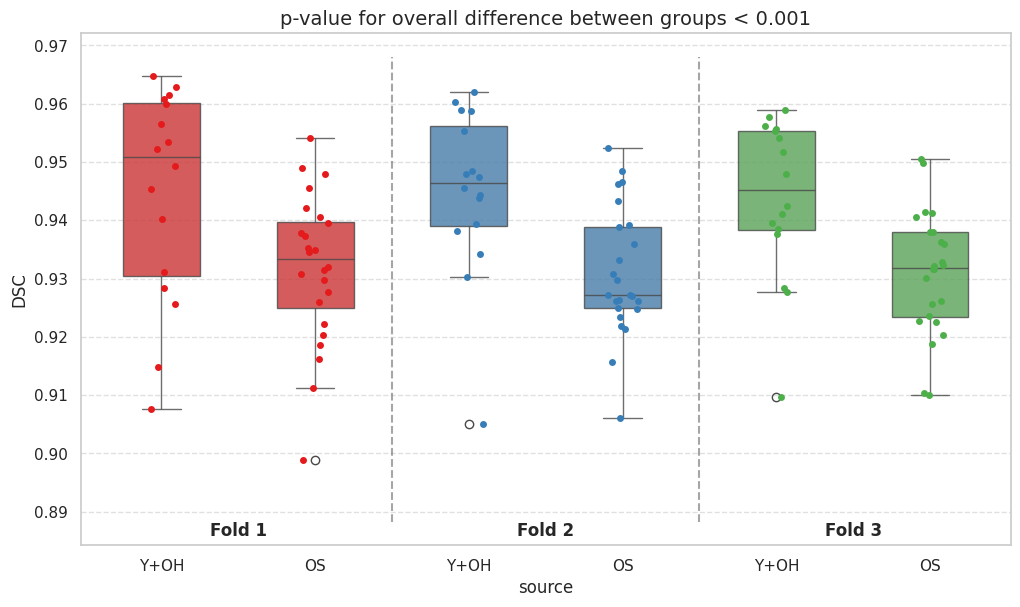

/tmp/ipykernel_2423881/4038155718.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


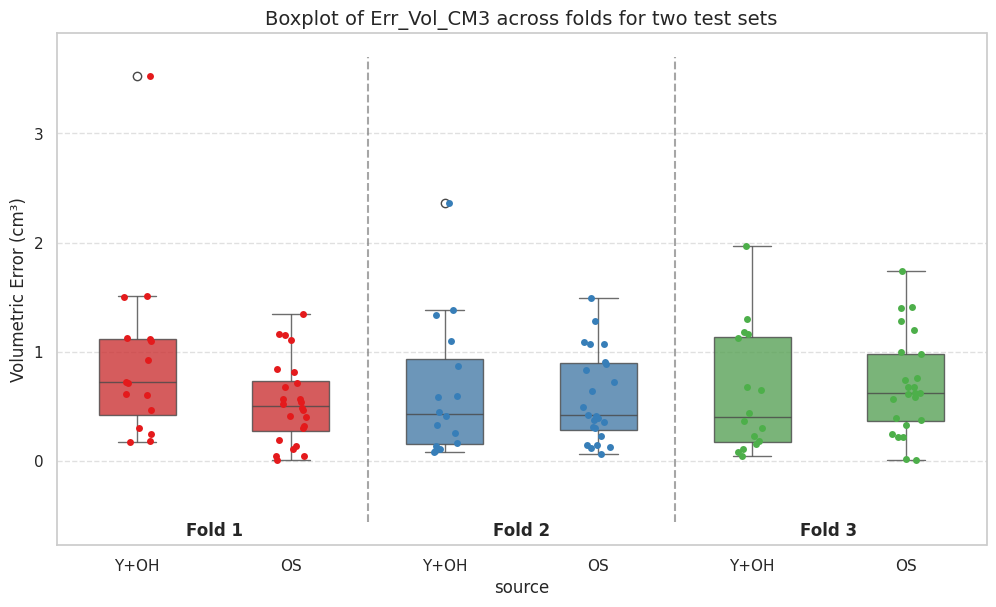

/tmp/ipykernel_2423881/4038155718.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


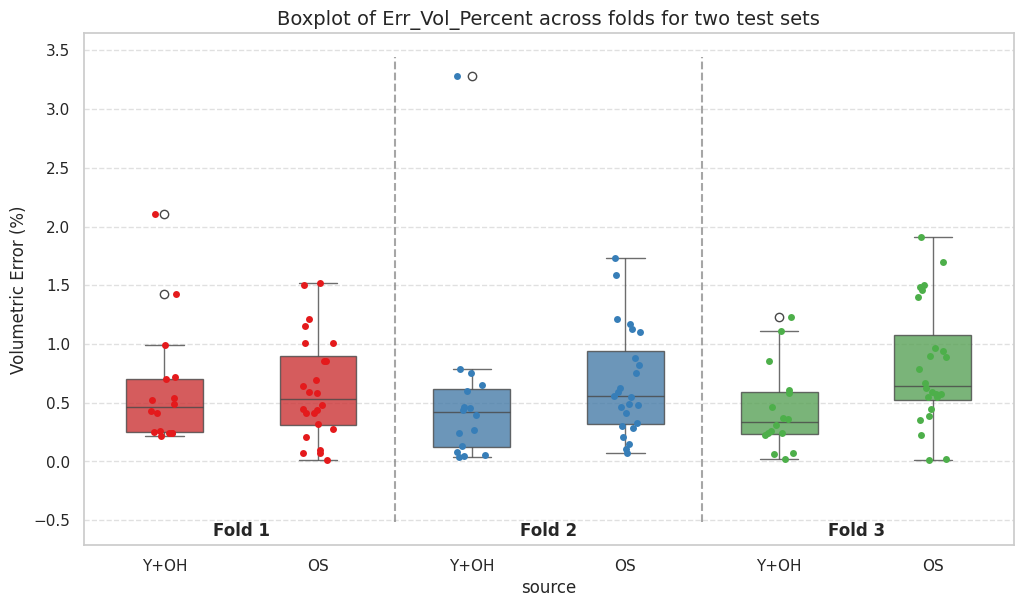

In [9]:
# ----------------------------
# ROBUST BOXPLOTS
# ----------------------------
if do_boxplots and df_combined_list:
    # Metrics to plot
    metrics = ['ASD', 'HSD', 'HSD95', 'DSC', 'Err_Vol_CM3', 'Err_Vol_Percent']
    metric_labels = {
        "ASD": "ASD",
        "HSD": "HSD",
        "HSD95": "HSD95",
        "DSC": "DSC",
        "Err_Vol_CM3": "Volumetric Error (cm³)",
        "Err_Vol_Percent": "Volumetric Error (%)"
    }

    # Create output folder for boxplots
    output_dir_boxplots = f"figures_boxplots_{muscle}"
    os.makedirs(output_dir_boxplots, exist_ok=True)

    # ----------------------------
    # Build ordered_sources based on actual data present
    # ----------------------------
    existing_sources = df_combined['source'].unique()
    
    # Sort sources by fold number, then by group (healthy first)
    ordered_sources = sorted(existing_sources, key=lambda x: (
        int(re.search(r'Fold_(\d+)', x).group(1)),
        0 if 'healthy' in x else 1
    ))

    # Convert source column to categorical to respect the desired order
    df_combined["source"] = pd.Categorical(
        df_combined["source"],
        categories=ordered_sources,
        ordered=True
    )

    # ----------------------------
    # Determine number of folds actually present and create a color palette
    # ----------------------------
    folds_in_plot = sorted(set(int(re.search(r'Fold_(\d+)', s).group(1)) for s in ordered_sources))
    fold_palette = sns.color_palette("Set1", n_colors=max(1, len(folds_in_plot)))

    # ----------------------------
    # Loop over each metric to create boxplots
    # ----------------------------
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        # Assign colors to each source based on fold number
        palette = []
        for src in ordered_sources:
            fold_num = int(re.search(r'Fold_(\d+)', src).group(1)) - 1  # zero-based index
            palette.append(fold_palette[fold_num])

        # Create the boxplot
        sns.boxplot(
            data=df_combined,
            x="source",
            y=metric,
            order=ordered_sources,
            palette=palette,
            width=0.5,
            boxprops=dict(alpha=0.8),
            whiskerprops=dict(alpha=0.8),
            capprops=dict(alpha=0.8),
            medianprops=dict(alpha=0.8),
            ax=ax
        )

        # Overlay individual data points
        for i, src in enumerate(ordered_sources):
            group = df_combined[df_combined["source"] == src]
            sns.stripplot(
                data=group,
                x="source",
                y=metric,
                order=ordered_sources,
                color=palette[i],
                jitter=True,
                size=5,
                alpha=1.0,
                ax=ax
            )

        # Add gridlines and set ticks below plots
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)
        ax.set_axisbelow(True)
        ax.set_xticks(range(len(ordered_sources)))
        ax.set_xticklabels(
            ["Y+OH" if "healthy" in s else "OS" for s in ordered_sources]
        )

        # Annotate fold numbers below x-axis
        ymin, ymax = ax.get_ylim()
        label_y = ymin - 0.10 * (ymax - ymin)  # place below min
        for f in folds_in_plot:
            mid = 2 * (f - 1) + 0.5
            ax.text(mid, label_y, f"Fold {f}", ha="center", va="top", fontsize=12, fontweight="bold")

        # Add vertical separators between folds
        for f in folds_in_plot[1:]:
            x_pos = 2 * (f - 1) - 0.5
            ax.vlines(x=x_pos, ymin=label_y, ymax=ymax, colors="grey", linestyles="--", alpha=0.7)

        # Title handling for DSC metric with p-value
        if metric == "DSC":
            p_text = "p-value for overall difference between groups < 0.001" if p_value_group < 0.001 else f"p-value = {p_value_group:.4f}"
            plt.title(f'{p_text}', fontsize=14)
        else:
            plt.title(f'Boxplot of {metric} across folds for two test sets', fontsize=14)

        plt.subplots_adjust(bottom=0.24)
        plt.ylabel(metric_labels.get(metric, metric))
        plt.savefig(os.path.join(output_dir_boxplots, f"boxplot_{metric}.pdf"))
        plt.show()
